# Interactive Example

## 1. Run PhaseNet in terminal or use QuakeFlow API

Note: Please only use the QuakeFlow API for debugging and testing on small datasets. Do not run large jobs using the QuakeFlow API. The computational cost can be high for us.

```bash
uvicorn --app-dir=phasenet app:app --reload --port 8000
```

In [7]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import obspy
import requests
sys.path.insert(0, os.path.abspath("../"))

In [8]:
# PHASENET_API_URL = "http://127.0.0.1:8000"
# PHASENET_API_URL = "http://phasenet.quakeflow.com" ## gcp
PHASENET_API_URL = "http://test.quakeflow.com:8001" ## local machine
# PHASENET_API_URL = "http://131.215.74.195:8001" ## local machine

## 2. Prepare seismic waveforms

Find more details in obspy's tutorials: 

[FDSN web service client for ObsPy](https://docs.obspy.org/packages/obspy.clients.fdsn.html#module-obspy.clients.fdsn)

[Mass Downloader for FDSN Compliant Web Services](https://docs.obspy.org/packages/autogen/obspy.clients.fdsn.mass_downloader.html#module-obspy.clients.fdsn.mass_downloader)



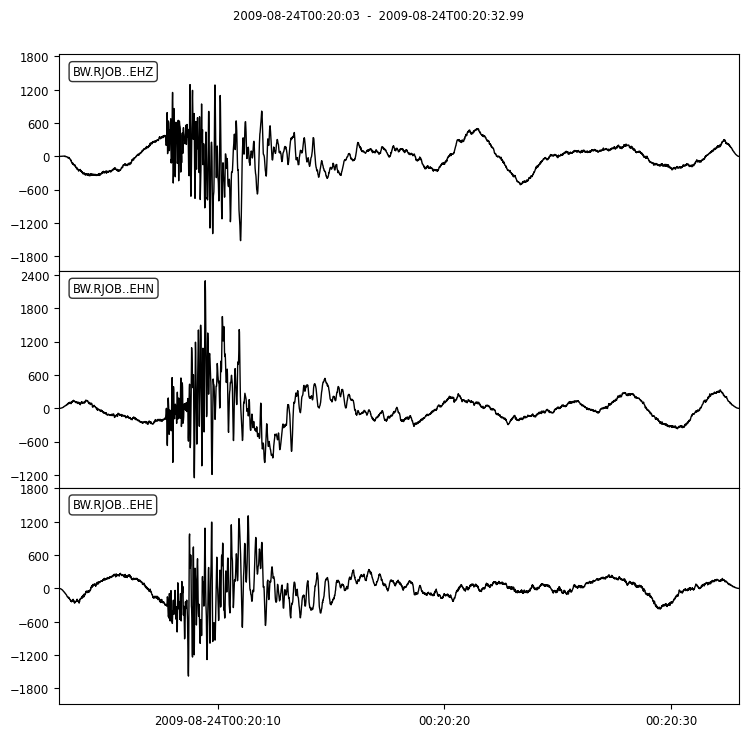

In [9]:
import obspy
stream = obspy.read()
stream.plot();

In [10]:
## Extract 3-component data
stream = stream.sort()
assert(len(stream) == 3)
data = []
for trace in stream:
    data.append(trace.data)
data = np.array(data).T
assert(data.shape[-1] == 3)

data_id = stream[0].get_id()[:-1]
timestamp = stream[0].stats.starttime.datetime.strftime("%Y-%m-%dT%H:%M:%S.%f")[:-3]

## 3. Predict P/S-phase picks using PhaseNet

In [11]:
req = {"id": [data_id],
       "timestamp": [timestamp],
       "vec": [data.tolist()]}

resp = requests.post(f'{PHASENET_API_URL}/predict', json=req)
print(resp)
print('Picks', resp.json())

<Response [200]>
Picks [{'station_id': 'BW.RJOB..EH', 'phase_time': '2009-08-24T00:20:07.710', 'phase_score': 0.978, 'phase_type': 'P', 'dt': 0.01}, {'station_id': 'BW.RJOB..EH', 'phase_time': '2009-08-24T00:20:08.680', 'phase_score': 0.924, 'phase_type': 'S', 'dt': 0.01}]


## 4. Get both picks and prediction (time series)

<Response [200]>
Picks [{'station_id': 'BW.RJOB..EH', 'phase_time': '2009-08-24T00:20:07.710', 'phase_score': 0.978, 'phase_type': 'P', 'dt': 0.01}, {'station_id': 'BW.RJOB..EH', 'phase_time': '2009-08-24T00:20:08.680', 'phase_score': 0.924, 'phase_type': 'S', 'dt': 0.01}]


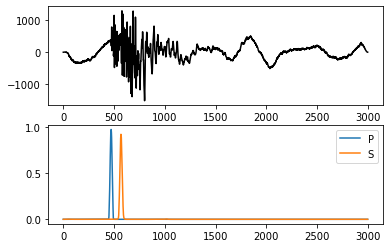

In [12]:
resp = requests.post(f'{PHASENET_API_URL}/predict_prob', json=req)
print(resp)
picks, preds = resp.json() 
preds = np.array(preds)
print('Picks', picks)

plt.figure()
plt.subplot(211)
plt.plot(data[:,-1], 'k', label="Z")
plt.subplot(212)
plt.plot(preds[0, :, 0, 1], label="P")
plt.plot(preds[0, :, 0, 2], label="S")
plt.legend()
plt.show();